# This Notebook uses the R Kernel to Interact with CAS via REST!
Copyright (c) 2017 SAS Institute Inc.

## Useful Functions

### REST request

In [1]:
# Shortcut to help you perform actions without seeing REST request
#
# Parameters
#   actionset.action: The API action endpoint to be performed
#   params: The action parameters to be passed along with the request
#
# Return: The Response from the POST request

makeRequest <- function(actionset.action, params){
    return(POST(
        paste(hostname, 'cas', 'sessions', sess, 'actions', actionset.action, sep='/'),
        body = params,
        authenticate(username, pwd),
        content_type('application/json'),
        accept_json(),
        encode='json',
        verbose()))
}

### Action output

In [2]:
# Automatically display the results of an action as a list with headers (headers can be turned off)
#
# Parameters
#   varname: The object returned by the 'makeRequest' function which contains a server response
#   result: Action Dependent name of result specified in JSON
#   header: Optional parameter to specify part of output
#
# Return: The pretty printed output of the JSON from the server

pprint <- function(varname, result, header){
    if (is.null(content(varname)$results[[result]]$rows) == F) {
    df <-t(as.data.table(content(varname)$results[[result]]$rows))
    cols <- which(names(unlist(content(varname)$results[[result]]$schema))=='name')
    colnames(df) <- c(t(unlist(content(varname)$results[[result]]$schema)[cols]))
    rownames(df) <- NULL
    } else {df <- data.frame(content(varname)$results[[result]])}
    if (header) {return(list(result, df))} else {return(output <- df)}
}

# Parses JSON that is returned by CAS and returns as a list
#
# Parameters
#   varname: The object returned by the 'makeRequest' function which contains a server response
#   header: Optional parameter to specify part of output, DEFAULT: True
#
actionOutput <- function(var, header = T){
    return(lapply(names((lapply(content(var)$results, '[[', 1))), pprint, varname = var, header = header))
}

### CAS action

In [3]:
# To be run like a CAS action, sends the request and parses the response
#
# Parameters
#   actionset.action: The name of the API endpoint action to execute
#   params: optional parameters if needed by the API endpoint
#   output: By Default, T specifies we want to surface the response to the notebook UI, DEFAULT: T
#   header: Optional parameter to specify part of output, DEFAULT: T
#
# Return: The Error message, or the pretty printed output from 'actionOutput' function

casAction <- function(actionset.action, params, output = T, header = T){
    var <- makeRequest(actionset.action, params)
    if (grepl('ERROR', content(var)$log)) {return(content(var)$log)} else
    if (output == T) {if (header) {return(actionOutput(var))} else {return(data.frame(actionOutput(var, header)))}}
}

### Fetch data

In [4]:
# A function meant to be a Fetch shortcut, (defaults to 10 rows, 10,000 row limit)
#
# Parameters
#   tbl: Name of the table to perform the 'table.fetch' action on
#   to: Number of rows to fetch, DEFAULT: 10
#   maxRows: Max number of rows to fetch, DEFAULT: 10000
# Return: The output formatted to look like a DataFrame

fetch <- function(tbl, to = 10, maxRows = 10000){
    req <- makeRequest('table.fetch', list(table = tbl, to = to, maxRows = maxRows))
    df <-t(as.data.table(content(req)$results$Fetch$rows))
    cols <- which(names(unlist(content(req)$results$Fetch$schema))=='name')
    colnames(df) <- c(t(unlist(content(req)$results$Fetch$schema)[cols]))
    rownames(df) <- df[, 1]
    return(df[, -1])
}

### Bring all data locally

In [5]:
# A function that allows you to pull the data from CAS into client memory for full R functionality
#
# Parameters
#   tbl: Name of the table to load locally
# Return: The output formatted to look like a DataFrame

toFrame <- function (tbl){
    casAction('cardinality.summarize', list(table = tbl, cardinality = list(name = 'cols', replace = T)))
    nrows <- unlist(actionOutput(makeRequest('fedSQL.execDirect', list(query = paste("SELECT COUNT(*) FROM", tbl))), F))
    tmp <- fetch('cols', to = nrows, maxRows = nrows)            # get all rows
    colnames(tmp) <- gsub('_',  '', colnames(tmp), fixed = TRUE) # substitute out underscores in column names
    tmp[,1] <- gsub('_', '', tmp[,1])                            # substitute out underscores in first column
    tmp <- data.frame(tmp)                                       # convert to a data frame
    n <- unlist(subset(tmp, TYPE == 'N')$VARNAME)                # find the numeric variables
    tmp <- fetch(tbl, to = nrows, maxRows = nrows)               # get all rows
    colnames(tmp) <- gsub('_',  '', colnames(tmp), fixed = TRUE) # substitute out underscores in column names
    tmp <- data.frame(tmp)
    tmp <- data.frame(lapply(tmp, as.character), stringsAsFactors = FALSE)
    tmp[, n] <- apply(tmp[, n], 2, function(x) as.numeric(x))    # replace char with numeric for numeric
    tmp[tmp == ''] <- NA
    return(tmp)
}

## Setup the Jupyter Notebook for Analysis

In [6]:
# Load the necessary packages
suppressPackageStartupMessages(library(reshape2))
suppressPackageStartupMessages(library(data.table))
library(httr)
library(ggplot2)
options(warn=-1)

# Define hostname, data file, and credentials
hostname   <- 'hostname:port'
indata     <- 'hmeq' #sas7bdat
indata_dir <-'/viyafiles' #location of the file
username   <- 'username'
pwd        <- 'password'

# Create a new session
sess <- content(POST(paste(hostname, 'cas', 'sessions', sep='/'), authenticate(username, pwd)))$session

# Create a CAS library called DMLib pointing to the defined directory
## Note, need to specify the srctype is path, otherwise it defaults to HDFS
DMlib <- makeRequest('table.addCaslib', list(name = 'DMlib', dataSource = list(srcType = 'path'), path = indata_dir))

# Load the relevant tables In-Memory if they do not already exist
## Note, this is a server side data load, not being loaded from the client, name sure to have the appropriate file type
inMem <- makeRequest('table.loadtable', list(path = paste0(indata,'.sas7bdat'), casOut = indata))

## Investigate the Data

In [7]:
fetch(indata)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
1,1,1100,25860,39025,HomeImp,Other,10.5,0,0,94.36667,1,9,NULL
2,1,1300,70053,68400,HomeImp,Other,7,0,2,121.8333,0,14,NULL
3,1,1500,13500,16700,HomeImp,Other,4,0,0,149.4667,1,10,NULL
4,1,1500,NULL,NULL,,,NULL,NULL,NULL,NULL,NULL,NULL,NULL
5,0,1700,97800,112000,HomeImp,Office,3,0,0,93.33333,0,14,NULL
6,1,1700,30548,40320,HomeImp,Other,9,0,0,101.466,1,8,37.11361
7,1,1800,48649,57037,HomeImp,Other,5,3,2,77.1,1,17,NULL
8,1,1800,28502,43034,HomeImp,Other,11,0,0,88.76603,0,8,36.88489
9,1,2000,32700,46740,HomeImp,Other,3,0,2,216.9333,1,12,NULL
10,1,2000,NULL,62250,HomeImp,Sales,16,0,0,115.8,0,13,NULL


## Creating a Repeatable Process

#### Every time we want to perform an action via REST APIs,  we will have to do the previous steps of making the request and parsing the response. To make our lives easier, we've created wrapper functions to clean up the code.

##### <font color='blue'>['makeRequest'](#REST-request)</font> is a function that will perform an http request given a cas action to perform and optional parameters to pass along
##### <font color='blue'>['actionOutput'](#Action-output)</font> and <font color='blue'>['pprint'](#Action-output)</font> are functions that handle the parsing of a response as a result of an http request
##### <font color='blue'>['casAction'](#CAS-action) </font> is a wrapper for the 3 previous functions, enabling us to make a one line call that will make the request, parse the response and output it to the notebook

## Get Summary Statistics

In [8]:
# Use CAS to get table of summary statistics
casAction('cardinality.summarize', list(table = indata, cardinality = list(name = 'data.card', replace = T)))

# Bring data to local dataframe
data.card <- toFrame('data.card')

# Manipulate dataframe using R syntax to present
data.card$PCTMISS <- with(data.card, NMISS/NOBS)
noquote('Summary Statistics:')
data.card[c('VARNAME','TYPE','PCTMISS','NMISS','NOBS', 'MIN','MAX','MEAN','STDDEV','SKEWNESS','KURTOSIS')]

list()

[1] Summary Statistics:

VARNAME,TYPE,PCTMISS,NMISS,NOBS,MIN,MAX,MEAN,STDDEV,SKEWNESS,KURTOSIS
BAD,N,0.00000000,0,5960,0.0000000,1.0000,1.994966e-01,3.996555e-01,1.5043167,0.2630568
LOAN,N,0.00000000,0,5960,1100.0000000,89900.0000,1.860797e+04,1.120748e+04,2.0237807,6.9325898
MORTDUE,N,0.08691275,518,5960,2063.0000000,399550.0000,7.376082e+04,4.445761e+04,1.8144807,6.4818663
VALUE,N,0.01879195,112,5960,8000.0000000,855909.0000,1.017760e+05,5.738578e+04,3.0533443,24.3628049
REASON,C,0.04228188,252,5960,NA,NA,NA,NA,NA,NA
JOB,C,0.04681208,279,5960,NA,NA,NA,NA,NA,NA
YOJ,N,0.08640940,515,5960,0.0000000,41.0000,8.922268e+00,7.573982e+00,0.9884601,0.3720725
DEROG,N,0.11879195,708,5960,0.0000000,10.0000,2.545697e-01,8.460468e-01,5.3208703,36.8727634
DELINQ,N,0.09731544,580,5960,0.0000000,15.0000,4.494424e-01,1.127266e+00,4.0231496,23.5654487
CLAGE,N,0.05167785,308,5960,0.0000000,1168.2336,1.797663e+02,8.581009e+01,1.3434120,7.5995493


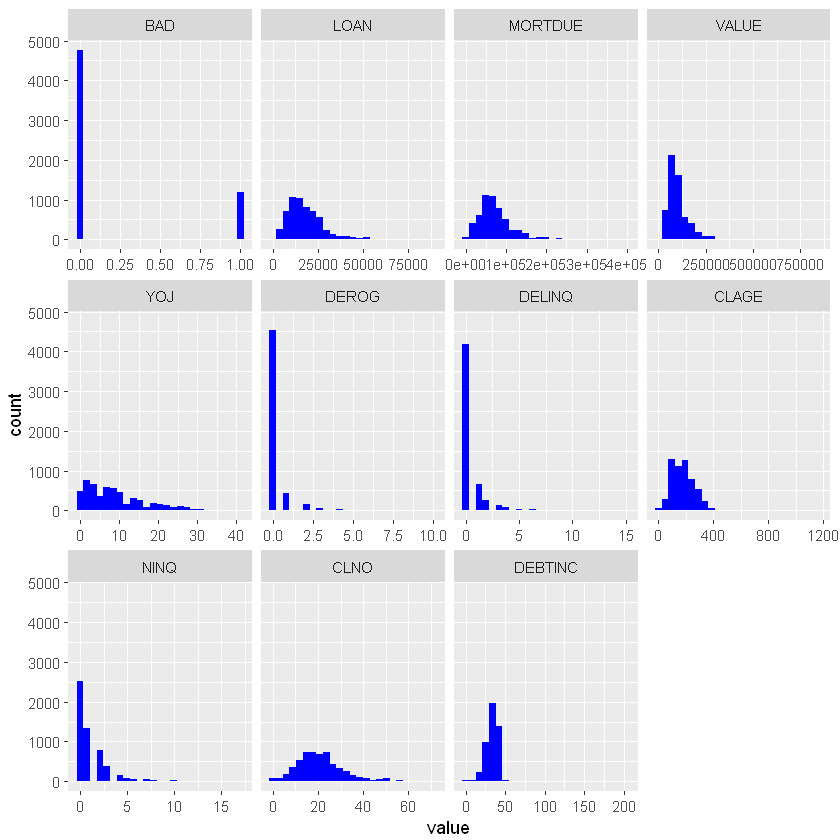

In [9]:
df <- toFrame(indata)
d <- melt(df[sapply(df, is.numeric)], id.vars=NULL)
ggplot(d,aes(x = value)) + 
    facet_wrap(~variable,scales = 'free_x') + 
    geom_histogram(fill = 'blue', bins = 25) 

## Impute Missing Values

In [10]:
# Impute continuous values with median, nominal with mode
casAction('dataPreprocess.impute', output = F, list(
    table             = indata,
    outVarsNamePrefix = 'IMP',
    methodContinuous  = 'MEDIAN',
    methodNominal     = 'MODE',
    inputs            = unlist(data.card$VARNAME)[-1],
    copyAllVars       = T,
    casOut            = list(name = indata, replace = T)
))

# Make sure the imputation worked correctly
fetch(indata, 5)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,...,IMP_DEBTINC,IMP_DELINQ,IMP_DEROG,IMP_LOAN,IMP_MORTDUE,IMP_NINQ,IMP_VALUE,IMP_YOJ,IMP_JOB,IMP_REASON
1,1,1100,25860,39025,HomeImp,Other,10.5,0,0,94.36667,...,34.81826,0,0,1100,25860,1,39025,10.5,Other,HomeImp
2,1,1300,70053,68400,HomeImp,Other,7,0,2,121.8333,...,34.81826,2,0,1300,70053,0,68400,7,Other,HomeImp
3,1,1500,13500,16700,HomeImp,Other,4,0,0,149.4667,...,34.81826,0,0,1500,13500,1,16700,4,Other,HomeImp
4,1,1500,NULL,NULL,,,NULL,NULL,NULL,NULL,...,34.81826,0,0,1500,65019,1,89235.5,7,Other,DebtCon
5,0,1700,97800,112000,HomeImp,Office,3,0,0,93.33333,...,34.81826,0,0,1700,97800,0,112000,3,Office,HomeImp


## Partition the Data into Training and Validation Sets

In [11]:
# Partition the data
casAction('sampling.srs', output = F, list(
    table   = list(name = indata), 
    samppct = 70, 
    partind = T, 
    seed    = 68,
    output  = list(casout = list(name = indata, replace = T), copyVars = "ALL")
))

# Make sure the partition worked correctly using SQL
casAction('fedsql.execDirect', list(query = paste0("
    SELECT 
        CASE WHEN _PartInd_ = 1 THEN 'Training' ELSE 'Validation' END AS name,
        _PartInd_, 
        COUNT(*) AS obs 
    FROM ", indata, "
    GROUP BY 
        CASE WHEN _PartInd_ = 1 THEN 'Training' ELSE 'Validation' END,
        _PartInd_;
")))

NAME,_PartInd_,OBS
Training,1,4172
Validation,0,1788


# Build Models

## Set Variable and Parameter Shortcuts

In [12]:
### For models that can handle missing values
## Variable shortcuts
target          <- unlist(data.card$VARNAME[1])
class.inputs    <- unlist(subset(data.card, TYPE == 'C')$VARNAME)
interval.inputs <- unlist(subset(data.card, TYPE == 'N')$VARNAME[-1])
class.vars      <- c(target, class.inputs)
all.inputs      <- c(class.inputs, interval.inputs)

## Parameter shortcuts
params <- list(
    table    = list(name = indata, where = '_partind_ = 1'),
    target   = target, 
    inputs   = all.inputs, 
    nominals = class.vars,
    varImp   = T
)

### For models that cannot handle missing values
## Variable shortcuts
imp.class.inputs    <- paste0('IMP_', class.inputs)
imp.interval.inputs <- paste0('IMP_', interval.inputs)
imp.class.vars      <- c(target, imp.class.inputs)
imp.all.inputs      <- c(imp.class.inputs, imp.interval.inputs)

## Parameter shortcuts
imp.params <- list(
    table    = list(name = indata, where = '_partind_ = 1'),
    target   = target, 
    inputs   = imp.all.inputs, 
    nominals = imp.class.vars
)

# Standard output table name function
casOut <- function(model) {return(list(name = paste0(model,'_model'), replace = T))}

## Decision Tree

### Train

In [13]:
casAction('decisionTree.dtreeTrain', append(params, list(casOut = casOut('dt'))))

[[1]]
[[1]][[1]]
[1] "DTreeVarImpInfo"

[[1]][[2]]
     Variable  Importance Std       Count
[1,] "DEBTINC" 423.4964   179.39    2    
[2,] "DELINQ"  44.64995   0         1    
[3,] "CLNO"    10.51195   3.284298  2    
[4,] "DEROG"   8.072349   0.1705609 2    


[[2]]
[[2]][[1]]
[1] "ModelInfo"

[[2]][[2]]
      Descr                          Value   
 [1,] "Number of Tree Nodes"         15      
 [2,] "Max Number of Branches"       2       
 [3,] "Number of Levels"             6       
 [4,] "Number of Leaves"             8       
 [5,] "Number of Bins"               20      
 [6,] "Minimum Size of Leaves"       5       
 [7,] "Maximum Size of Leaves"       3188    
 [8,] "Number of Variables"          12      
 [9,] "Confidence Level for Pruning" 0.25    
[10,] "Number of Observations Used"  4172    
[11,] "Misclassification Error (%)"  14.42953


[[3]]
[[3]][[1]]
[1] "OutputCasTables"

[[3]][[2]]
     casLib  Name       Rows Columns
[1,] "DMlib" "dt_model" 15   27

### Score and Assess

In [14]:
MisclassificationPct <- data.frame(casAction('decisionTree.dtreeScore', header = F, list(
    table      = list(name = indata, where = '_partind_ = 0'),
    modelTable = 'dt_model'
)))[3, 'Value']
dt <- cbind(Model = 'Decision Tree', Misclassification = as.numeric(MisclassificationPct)/100)
dt

Model,Misclassification
Decision Tree,0.12639821029


## Random Forest

### Train

In [15]:
casAction('decisionTree.forestTrain', append(params, list(casOut = casOut('rf'))))

Variable,Importance,Std
DEBTINC,145.8296,101.7453
DELINQ,35.11743,14.46916
DEROG,19.78063,11.18193
VALUE,6.015498,13.81041
CLNO,5.426453,3.833829
NINQ,3.32611,6.121774
LOAN,1.596384,5.951966
JOB,1.372034,4.842406
CLAGE,1.214892,8.147505
YOJ,0.8273734,1.521188


### Score and Assess

In [16]:
MisclassificationPct <- data.frame(casAction('decisionTree.forestScore', header = F, list(
    table      = list(name = indata, where = '_partind_ = 0'), 
    modelTable = 'rf_model'
)))[3, 'Value']
rf <- cbind(Model = 'Random Forest', Misclassification = as.numeric(MisclassificationPct)/100)
rf

Model,Misclassification
Random Forest,0.12751677852


## Gradient Boosting

### Train

In [17]:
casAction('decisionTree.gbtreeTrain', append(params, list(seed = 7, casOut = casOut('gbt'))))

Variable,Importance,Std
DEBTINC,35.50955,44.07172
DELINQ,8.218795,5.071519
JOB,7.450607,1.825477
CLAGE,6.950221,2.393559
CLNO,5.56095,1.295386
YOJ,4.896468,1.597273
VALUE,4.328092,2.022971
LOAN,4.104148,1.501752
DEROG,4.092265,2.928396
MORTDUE,3.205846,1.201196


### Score and Assess

In [18]:
MisclassificationPct <- data.frame(casAction('decisionTree.gbtreeScore', list(
    table      = list(name = indata, where = '_partind_ = 0'),
    modelTable = 'gbt_model'
))[2])[3, 'Value']
gbt <- cbind(Model = 'Gradient Boosting', Misclassification = as.numeric(MisclassificationPct)/100)
gbt

Model,Misclassification
Gradient Boosting,0.084451901566


## Neural Network

### Train

In [19]:
casAction('neuralNet.annTrain', append(imp.params, list(casOut = casOut('nn'))))

[[1]]
[[1]][[1]]
[1] "ConvergenceStatus"

[[1]][[2]]
     Reason                                          
[1,] "The optimization exited on maximum iterations."


[[2]]
[[2]][[1]]
[1] "ModelInfo"

[[2]][[2]]
      Descr                         Value         
 [1,] "Model"                       "Neural Net"  
 [2,] "Number of Observations Used" "4172"        
 [3,] "Number of Observations Read" "4172"        
 [4,] "Target/Response Variable"    "BAD"         
 [5,] "Number of Nodes"             "20"          
 [6,] "Number of Input Nodes"       "18"          
 [7,] "Number of Output Nodes"      "2"           
 [8,] "Number of Hidden Nodes"      "0"           
 [9,] "Number of Weight Parameters" "18"          
[10,] "Number of Bias Parameters"   "2"           
[11,] "Architecture"                "GLIM"        
[12,] "Number of Neural Nets"       "1"           
[13,] "Objective Value"             "1.5770969207"


[[3]]
[[3]][[1]]
[1] "OptIterHistory"

[[3]][[2]]
      Progress Objective Loss    
 [1,] 1        4.499834  4.499834
 [2,] 2        2.813818  2.813818
 [3,] 3        1.743715  1.743715
 [4,] 4        1.64579   1.64579 
 [5,] 5        1.608081  1.608081
 [6,] 6        1.595154  1.595154
 [7,] 7        1.583373  1.583373
 [8,] 8        1.580727  1.580727
 [9,] 9        1.577442  1.577442
[10,] 10       1.577097  1.577097


[[4]]
[[4]][[1]]
[1] "OutputCasTables"

[[4]][[2]]
     casLib  Name       Rows Columns
[1,] "DMlib" "nn_model" 20   15

### Score and Assess

In [20]:
MisclassificationPct <- data.frame(casAction('neuralNet.annScore', list(
    table      = list(name = indata, where = '_partind_ = 0'),
    modelTable = 'nn_model'
)))[3, 'Value']
nn <- cbind(Model = 'Neural Network', Misclassification = as.numeric(MisclassificationPct)/100)
nn

Model,Misclassification
Neural Network,0.15771812081


## CAS Final Assessment

In [21]:
# Combine the assessments and order by most accurate on validation data
miss <- data.frame(rbind(dt, rf, gbt, nn))
miss <- miss[order((miss[,'Misclassification'])),]
rownames(miss) <- NULL
miss

Model,Misclassification
Gradient Boosting,0.084451901566
Decision Tree,0.12639821029
Random Forest,0.12751677852
Neural Network,0.15771812081


## Compare XGBoost Model

In [22]:
# Load additional packages
suppressPackageStartupMessages(library(caret))
suppressPackageStartupMessages(library(xgboost))

# Bring data locally and make sure it's in the right format
df <- toFrame(indata)
df <- df[c(target, class.inputs, interval.inputs, 'PartInd')]
    
# Create dummy variables through one-hot encoding
df.dum <- df[,class.inputs]
dummies <- dummyVars('~ .', data = df.dum)
df.ohe <- as.data.frame(predict(dummies, newdata = df))
df.all.combined <- cbind(df[,-c(which(colnames(df) %in% class.inputs))], df.ohe)
    
# Split into training and validation
train <- subset(df.all.combined, PartInd == '1')
valid <- subset(df.all.combined, PartInd == '0')
    
# Train the XGBoost model
set.seed(7)
xgboost <- xgboost(
    data = data.matrix(train[,-1]),
    label = data.matrix(train[,1]),
    missing = 'NAN',
    nround = 50,
    objective = "binary:logistic",
    eta = 0.1,
    max_depth = 6,  
    subsample = 0.5,
    colsample_bytree = 0.5,
    seed = 7
)





[0]	train-error:0.117450
[1]	train-error:0.124640
[2]	train-error:0.116970
[3]	train-error:0.123921
[4]	train-error:0.125839
[5]	train-error:0.121764
[6]	train-error:0.123202
[7]	train-error:0.112416
[8]	train-error:0.107383
[9]	train-error:0.104746
[10]	train-error:0.097076
[11]	train-error:0.096357
[12]	train-error:0.091802
[13]	train-error:0.087728
[14]	train-error:0.086050
[15]	train-error:0.083174
[16]	train-error:0.083653
[17]	train-error:0.085331
[18]	train-error:0.083893
[19]	train-error:0.081016
[20]	train-error:0.080777
[21]	train-error:0.079099
[22]	train-error:0.076942
[23]	train-error:0.076702
[24]	train-error:0.075743
[25]	train-error:0.074784
[26]	train-error:0.075983
[27]	train-error:0.073826
[28]	train-error:0.072627
[29]	train-error:0.073106
[30]	train-error:0.074065
[31]	train-error:0.070949
[32]	train-error:0.070230
[33]	train-error:0.070230
[34]	train-error:0.069511
[35]	train-error:0.068552
[36]	train-error:0.066635
[37]	train-error:0.067354
[38]	train-error:0

## Score and Assess XGBoost on Validation Data

In [23]:
pred <- as.numeric(predict(xgboost, data.matrix(valid[,-1]), missing = 'NAN') > 0.5)
Misclassification <- mean(as.numeric(pred > 0.5) != valid[,1])
xgb <- cbind(Model = 'R - XGBoost', Misclassification)
xgb

Model,Misclassification
R - XGBoost,0.0844519015659955


## Final CAS and R Assessment

In [24]:
# Combine the assessments and order by most accurate on validation data
err <- data.frame(rbind(dt, rf, gbt, nn, xgb))
err[,-1] <- as.character(round(as.numeric(as.character(err[,-1])),11))
err <- err[order(err$Misclassification),]
rownames(err) <- NULL
err

Model,Misclassification
Gradient Boosting,0.08445190157
R - XGBoost,0.08445190157
Decision Tree,0.12639821029
Random Forest,0.12751677852
Neural Network,0.15771812081


## Deploy the CAS Gradient Boosting Model

In [25]:
# Generate score code to be operationalized
unload <- makeRequest('table.save', list(table = 'gbt_model', name = 'gbt_scorecode', replace = T))
content(unload)$log

[1] "NOTE: Cloud Analytic Services saved the file gbt_scorecode.sashdat in caslib DMlib.\n"

## End Session

In [26]:
casAction('session.endSession', list())

list()